In [15]:
%matplotlib
from matplotlib import pyplot
import matplotlib
import scipy.special
import scipy.integrate
import numpy as np
import numpy.polynomial

Using matplotlib backend: MacOSX


In [2]:
def legendre_series(f, n):
    def integrand(x, n):
        return scipy.special.eval_legendre(n, x)*f(x)
    # Approximate the inner product integral for each of the polynomials,
    # including the normalisation factor.
    return np.polynomial.legendre.Legendre(np.array([
        scipy.integrate.quad(integrand, -1, 1, args=(m,))[0] * (m + 0.5)
        for m in range(n + 1)
    ]))

In [3]:
def taylor_coefficient(f, k, a=15):
    if k == 0:
        return f(0)
    scale = np.exp(-a/k)
    # Honestly it's probably easier just to accept that this is magic; the
    # standard way of defining Taylor series with high-order derivatives and
    # factorials doesn't play nicely with numerical methods.
    return np.exp(a)/k * sum(
        (-1)**n * np.imag(f(scale * np.exp(1j*np.pi*(0.5-n)/k)))
        for n in range(1, k+1)
    )

def taylor_series(f, n, a=15):
    return np.polynomial.Polynomial([
        taylor_coefficient(f, k, a)
        for k in range(n+1)
    ])

In [4]:
class fourier_series:
    def __init__(self, f, n):
        self.a = np.empty((n+1,), dtype=np.float64)
        self.b = np.empty((n+1,), dtype=np.float64)
        self.n = n
        self.a[0] = scipy.integrate.quad(f, -1, 1)[0] * 0.5
        self.b[0] = 0
        def cosint(x, k): return f(x) * np.cos(k*np.pi*x)
        def sinint(x, k): return f(x) * np.sin(k*np.pi*x)
        for k in range(1, n+1):
            self.a[k] = scipy.integrate.quad(cosint, -1, 1, args=(k,))[0]
            self.b[k] = scipy.integrate.quad(sinint, -1, 1, args=(k,))[0]
        self._chebyshev = np.polynomial.chebyshev.Chebyshev(self.a)

    def __repr__(self):
        return "Fourier(" + ", ".join([
            "a=" + repr(self.a)[6:-1],
            "b=" + repr(self.b)[6:-1],
        ]) + ")"

    def __call__(self, xs):
        out = self._chebyshev(np.cos(np.pi*xs))
        for k in range(1, self.n+1):
            out += self.b[k] * np.sin(k*np.pi * xs)
        return out


In [5]:
def series_plot(f, xs, order, axes=None):
    if axes is None:
        _, axes = pyplot.subplots()
    fs = np.array([f(x) for x in xs])
    axes.plot(xs, fs, label="Exact", color='black', linewidth=2, dashes=(3, 3))
    axes.plot(xs, legendre_series(f, order)(xs), label="Legendre")
    axes.plot(xs, taylor_series(f, order)(xs), label="Taylor")
    axes.plot(xs, fourier_series(f, order)(xs), label="Fourier")
    axes.set_xlim((xs[0] - 0.03*(xs[-1]-xs[0]), xs[-1] + 0.03*(xs[-1]-xs[0])))
    mn, mx = np.min(fs), np.max(fs)
    axes.set_ylim((mn - 0.1*(mx-mn), mx + 0.1*(mx-mn)))
    axes.legend()
    return axes


In [12]:
def logistic(x):
    return 1 / (1 + np.exp(-5*x))

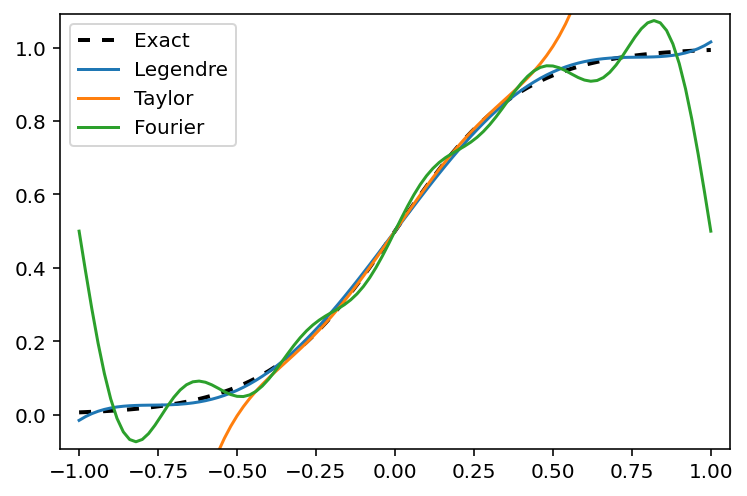

In [16]:
series_plot(logistic, np.linspace(-1, 1, 101), 5);